In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

In [4]:
df = pd.read_parquet('../data/cleaned/sp500.parquet')
df

,Date,Close,High,Low,Open,Volume,LogRet
0,2005-09-19,1231.020020,1237.910034,1227.650024,1237.910034,2076540000,NaN
1,2005-09-20,1221.339966,1236.489990,1220.069946,1231.020020,2319250000,-0.007895
2,2005-09-21,1210.199951,1221.520020,1209.890015,1221.339966,2548150000,-0.009163
3,2005-09-22,1214.619995,1216.640015,1205.349976,1210.199951,2424720000,0.003646
4,2005-09-23,1215.290039,1218.829956,1209.800049,1214.619995,1973020000,0.000551
...,...,...,...,...,...,...,...
5026,2025-09-11,6587.470215,6592.890137,6545.799805,6554.410156,5426460000,0.008450
5027,2025-09-12,6584.290039,6600.209961,6579.490234,6590.660156,4641640000,-0.000483
5028,2025-09-15,6615.279785,6619.620117,6602.069824,6603.490234,5045020000,0.004696
5029,2025-09-16,6606.759766,6626.990234,6600.109863,6624.129883,5359510000,-0.001289


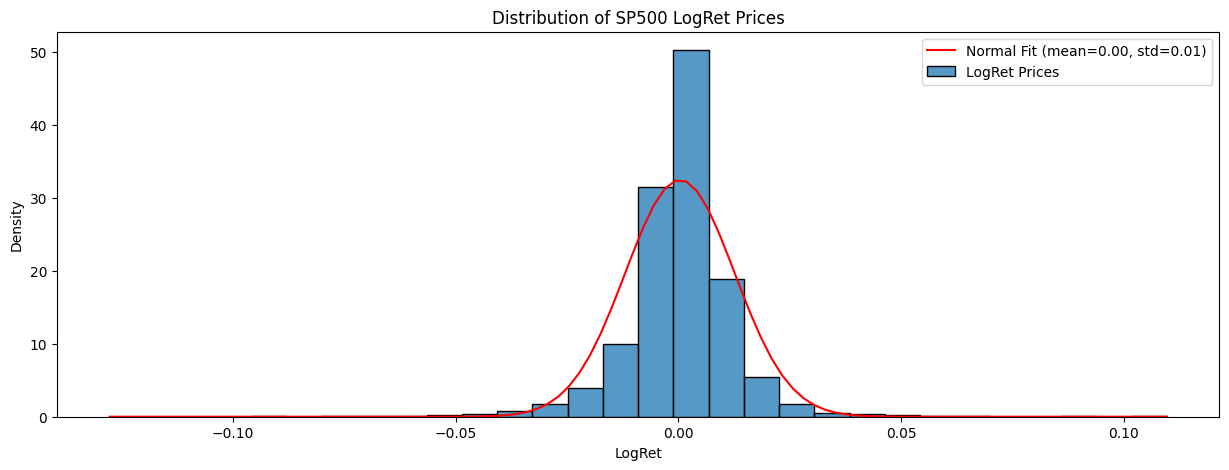

In [5]:
from scipy.stats import norm
import numpy as np

import matplotlib.pyplot as plt
df.dropna(inplace=True)
# Plot histogram of Close prices
plt.figure(figsize=(15, 5))
sns.histplot(df['LogRet'], kde=False, stat="density", bins=30, label='LogRet Prices')

# Fit a normal distribution to the data
mean, std = norm.fit(df['LogRet'])
x = np.linspace(df['LogRet'].min(), df['LogRet'].max(), 100)
pdf = norm.pdf(x, mean, std)

# Plot the normal distribution curve
plt.plot(x, pdf, 'r-', label=f'Normal Fit (mean={mean:.2f}, std={std:.2f})')
plt.title('Distribution of SP500 LogRet Prices')
plt.legend()
plt.show()

## Stationarity analysis

In [6]:

from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')

def stationarity_analysis(df, dataset_name, column_name = None):
    """
    column_name: specify the column to analyze, default is 'Close'
    Perform ADF and KPSS tests for stationarity analysis
    """
    data = df['Close'] if column_name is None else df[column_name]
    
    data.dropna(inplace=True)  # Drop NaN values for accurate testing
    
    print(f"\n{'='*50}")
    print(f"STATIONARITY ANALYSIS: {dataset_name.upper()}")
    print(f"{'='*50}")
    
    # ADF Test
    print("\n--- AUGMENTED DICKEY-FULLER TEST ---")
    adf_result = adfuller(data, autolag='AIC')
    print(f"ADF Statistic: {adf_result[0]:.6f}")
    print(f"p-value: {adf_result[1]:.6f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value:.6f}")
    
    if adf_result[1] <= 0.05:
        print("ADF Result: STATIONARY (Reject null hypothesis)")
    else:
        print("ADF Result: NON-STATIONARY (Fail to reject null hypothesis)")
    
    # KPSS Test
    print("\n--- KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST ---")
    kpss_result = kpss(data, regression='c', nlags='auto')
    print(f"KPSS Statistic: {kpss_result[0]:.6f}")
    print(f"p-value: {kpss_result[1]:.6f}")
    print("Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"\t{key}: {value:.6f}")
    
    if kpss_result[1] <= 0.05:
        print("KPSS Result: NON-STATIONARY (Reject null hypothesis)")
    else:
        print("KPSS Result: STATIONARY (Fail to reject null hypothesis)")
    
    # Combined interpretation
    print("\n--- COMBINED INTERPRETATION ---")
    adf_stationary = adf_result[1] <= 0.05
    kpss_stationary = kpss_result[1] > 0.05
    
    if adf_stationary and kpss_stationary:
        print("CONCLUSION: Series is STATIONARY")
    elif not adf_stationary and not kpss_stationary:
        print("CONCLUSION: Series is NON-STATIONARY")
    else:
        print("CONCLUSION: Results are INCONCLUSIVE - further investigation needed")

stationarity_analysis(df=df, dataset_name="S&P500_raw")
stationarity_analysis(df=df, dataset_name="S&P500_log_returns", column_name='LogRet')


STATIONARITY ANALYSIS: S&P500_RAW

--- AUGMENTED DICKEY-FULLER TEST ---
ADF Statistic: 2.214788
p-value: 0.998894
Critical Values:
	1%: -3.431658
	5%: -2.862118
	10%: -2.567078
ADF Result: NON-STATIONARY (Fail to reject null hypothesis)

--- KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST ---
KPSS Statistic: 10.284780
p-value: 0.010000
Critical Values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
KPSS Result: NON-STATIONARY (Reject null hypothesis)

--- COMBINED INTERPRETATION ---
CONCLUSION: Series is NON-STATIONARY

STATIONARITY ANALYSIS: S&P500_LOG_RETURNS

--- AUGMENTED DICKEY-FULLER TEST ---
ADF Statistic: -17.945452
p-value: 0.000000
Critical Values:
	1%: -3.431655
	5%: -2.862117
	10%: -2.567077
ADF Result: STATIONARY (Reject null hypothesis)

--- KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST ---
KPSS Statistic: 0.189312
p-value: 0.100000
Critical Values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
KPSS Result: STATIONARY (Fail to reject null hypothesis)

--- COMBIN

In [7]:
mean_lr = df['LogRet'].mean()
std_lr = df['LogRet'].std()
CLAMP_STD = 2

upper = mean_lr + CLAMP_STD * std_lr
lower = mean_lr - CLAMP_STD * std_lr

df['LogRet'] = np.where(df['LogRet'] > upper, upper,
                        np.where(df['LogRet'] < lower, lower, df['LogRet']))


In [8]:

df['LogRet'].mean()- df['LogRet'].std()

np.float64(-0.00931826083271606)

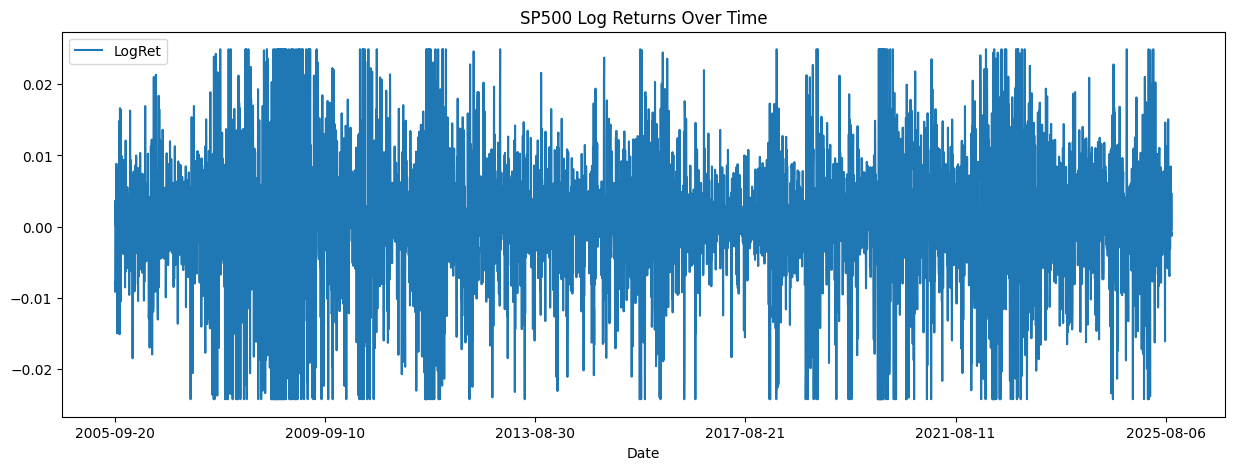

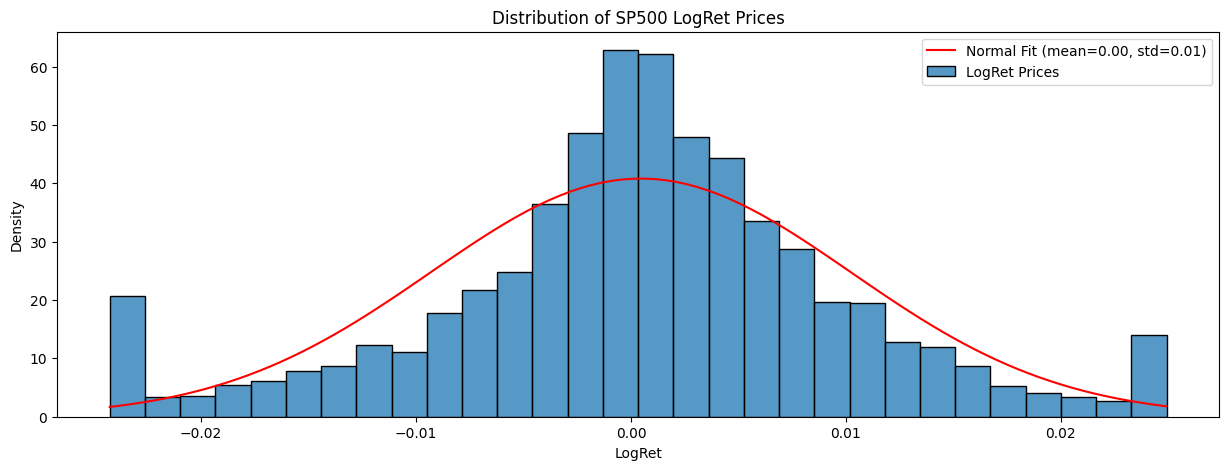

In [9]:
df.plot(x= 'Date', y='LogRet', title='SP500 Log Returns Over Time', figsize=(15,5))

# Plot histogram of Close prices
plt.figure(figsize=(15, 5))
sns.histplot(df['LogRet'], kde=False, stat="density", bins=30, label='LogRet Prices')

# Fit a normal distribution to the data
mean, std = norm.fit(df['LogRet'])
x = np.linspace(df['LogRet'].min(), df['LogRet'].max(), 100)
pdf = norm.pdf(x, mean, std)

# Plot the normal distribution curve
plt.plot(x, pdf, 'r-', label=f'Normal Fit (mean={mean:.2f}, std={std:.2f})')
plt.title('Distribution of SP500 LogRet Prices')
plt.legend()
plt.show()

In [10]:
# create a collumn calles highlow_range which is the difference between the high and low prices
df['highlow_range'] = df['High'] - df['Low']


In [11]:
cordf = df.drop(columns=['Date']).corr()
# cordf = df.drop(columns=['Date']).corr()
cordf

,Close,High,Low,Open,Volume,LogRet,highlow_range
Close,1.000000,0.999914,0.999918,0.999834,0.114524,0.022796,0.513918
High,0.999914,1.000000,0.999864,0.999928,0.118703,0.014818,0.521229
Low,0.999918,0.999864,1.000000,0.999907,0.110566,0.016830,0.507062
Open,0.999834,0.999928,0.999907,1.000000,0.115361,0.008396,0.515222
Volume,0.114524,0.118703,0.110566,0.115361,1.000000,-0.053951,0.481497
LogRet,0.022796,0.014818,0.016830,0.008396,-0.053951,1.000000,-0.096326
highlow_range,0.513918,0.521229,0.507062,0.515222,0.481497,-0.096326,1.000000


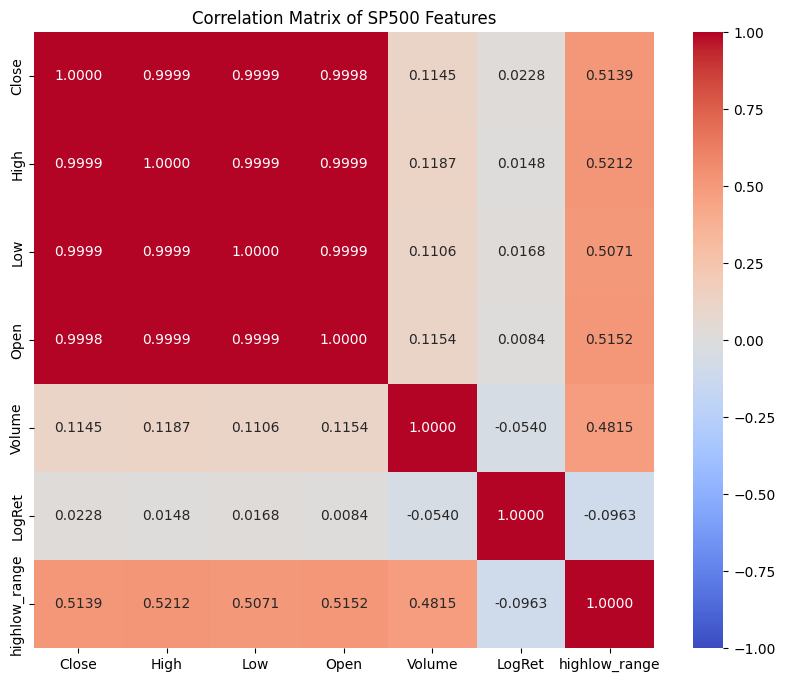

In [12]:
# correlation plot of all the features in the dataframe
plt.figure(figsize=(10, 8))
sns.heatmap(cordf, annot=True, fmt=".4f", cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix of SP500 Features')
plt.show()

In [13]:
df.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'LogRet',
       'highlow_range'],
      dtype='object')

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit  # For guidance, but implementing custom rolling for financial data

# Step 1: Define Elman RNN Model
class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(ElmanRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Step 2: Custom Dataset for Sequences
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, seq_len=10):
        self.data = data
        self.targets = targets
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len]
        y = self.targets[idx + self.seq_len]
        return torch.FloatTensor(x), torch.FloatTensor([y])

# Step 3: Data Preparation (No global scaling; features exclude Date and LogRet)
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'highlow_range']
X = df[features].values
y = df['LogRet'].shift(-1).dropna().values  # Next LogRet; len N-1
X = X[:-1]  # Align; assume df sorted by Date

# Parameters
seq_len = 10
batch_size = 32
hidden_size = 100
num_layers = 1
learning_rate = 0.01
epochs = 500
n_folds = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = len(features)
output_size = 1

# Step 4: Custom Rolling Window CV (Fixed train window, sliding test; avoids leakage per fold)
n_samples = len(X)
train_window = int(0.7 * n_samples)  # Fixed train window size (adjust ratio as needed)
test_size = (n_samples - train_window) // n_folds  # Approximate equal test sizes
results = {'fold': [], 'rmse': [], 'mae': []}

for fold in range(n_folds):
    train_start = fold * test_size
    train_end = min(train_start + train_window, n_samples)
    test_start = train_end
    test_end = min(test_start + test_size, n_samples)
    
    if train_end - train_start < seq_len + 1 or test_end - test_start < seq_len + 1:
        print(f"Skipping fold {fold}: Insufficient data")
        continue
    
    # Extract fold data
    X_train = X[train_start:train_end]
    y_train = y[train_start:train_end]
    X_test = X[test_start:test_end]
    y_test = y[test_start:test_end]
    
    # Scale PER FOLD (fit on train only to avoid leakage)
    scaler_X = StandardScaler().fit(X_train)
    X_train_scaled = scaler_X.transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))
    y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    
    # Create datasets/loaders
    train_dataset = TimeSeriesDataset(X_train_scaled, y_train_scaled, seq_len)
    test_dataset = TimeSeriesDataset(X_test_scaled, y_test_scaled, seq_len)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Model, loss, optimizer
    model = ElmanRNN(input_size, hidden_size, output_size, num_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training
    model.train()
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()
    
    # Evaluation
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch_x, _ in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            predictions.extend(outputs.squeeze().cpu().numpy())
    
    predictions = np.array(predictions)
    true_y = y_test_scaled[seq_len:]  # Align with predictions length
    predictions = predictions[:len(true_y)]  # Ensure match
    
    rmse = np.sqrt(mean_squared_error(true_y, predictions))
    mae = mean_absolute_error(true_y, predictions)
    
    results['fold'].append(fold)
    results['rmse'].append(rmse)
    results['mae'].append(mae)
    
    print(f"Fold {fold}: RMSE = {rmse:.4f}, MAE = {mae:.4f} (Train: {train_start}-{train_end}, Test: {test_start}-{test_end})")

# Step 5: Summary
results_df = pd.DataFrame(results)
print("\nRolling Window CV Summary:")
print(results_df)
print(f"Mean RMSE: {results_df['rmse'].mean():.4f} (+/- {results_df['rmse'].std() * 2:.4f})")
print(f"Mean MAE: {results_df['mae'].mean():.4f} (+/- {results_df['mae'].std() * 2:.4f})")

# Optional: For original scale metrics, inverse transform predictions/true_y per fold and recompute

KeyboardInterrupt: 